In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ZGlobalLib.gpu_utils import use_gpu
use_gpu(0)

2024-03-18 11:16:07.674347: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 11:16:08.100819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [3]:
from HistoLib import generator
from HistoLib import utils
from HistoLib import models
from HistoLib import traintest
from HistoLib import gradcam

In [49]:
resolution = '40x'      # One of ['20x', '40x', None]
class_type = 'macro'    # One of ['macro', 'micro']
exclude_pd = False
train_split = 0.7
val_split = 0.15
random_state = 2

In [4]:
resolution = '20x'      # One of ['20x', '40x', None]
class_type = 'macro'    # One of ['macro', 'micro']
exclude_pd = False
train_split = 0.8
val_split = 0.1
random_state = 967

In [50]:
utils.dataset_description()

Total images 692
Total patients 45


20x  40x  Total
aca_bd   58   46    104
aca_md   44   46     90
aca_pd   45   42     87
nor      85   66    151
scc_bd   50   49     99
scc_md   30   36     66
scc_pd   48   47     95
Total   360  332    692

## Get images

In [51]:
train_generator, val_generator, test_generator, class_names, df1, df2, df3 = generator.get_patient_generators(resolution, 
                                                                                               class_type, exclude_pd, batch_size=8, 
                                                                                               train_split=train_split, 
                                                                                               val_split=val_split,
                                                                                               debug=True,
                                                                                               random_state=random_state
                                                                                              )

Images (300x400)      Training: 236 | Validation: 46  | Test: 50  | Total: 332
Patients              Training: 24  | Validation: 7   | Test: 6   | Total: 37 
Class aca    (id 0)   Training: 101 | Validation: 16  | Test: 17  | Total: 134
Class nor    (id 1)   Training: 39  | Validation: 14  | Test: 13  | Total: 66 
Class scc    (id 2)   Training: 96  | Validation: 16  | Test: 20  | Total: 132


In [52]:
df1['group'] = 'train'
df2['group'] = 'val'
df3['group'] = 'test'

In [53]:
import pandas as pd
df = pd.concat([df1, df2, df3]).reset_index(drop=True)
df.image_id = df.image_id.astype(int)
df2 = pd.read_csv('../LungsPublic/data/data.csv')
df = df2.merge(df, on=['superclass', 'subclass', 'resolution', 'image_id'])

In [56]:
import numpy as np
np.array(sorted(df[df.group=='test'].patient_id.unique()))

array([11, 15, 20, 25, 32, 43])

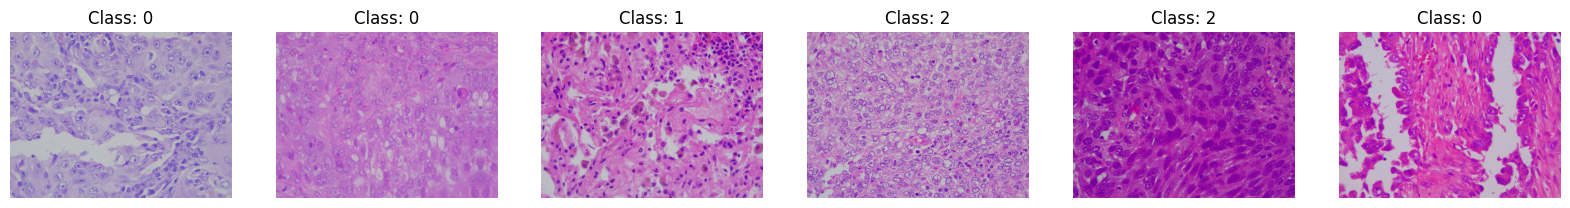

In [7]:
train_generator.show_generator()

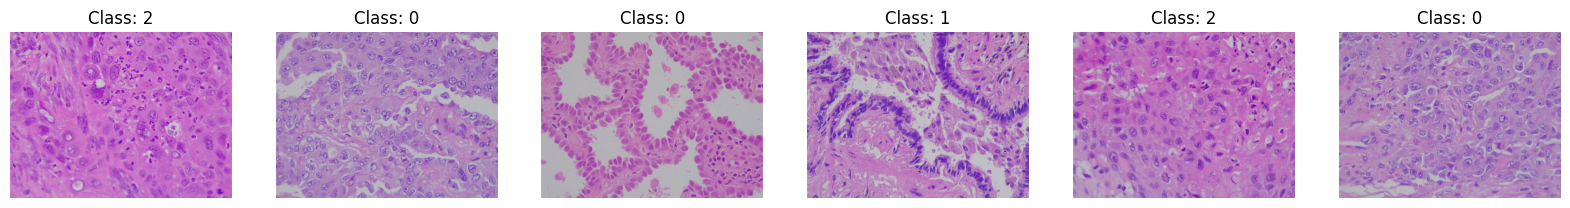

In [8]:
val_generator.show_generator()

## Train Model

In [9]:
class_weights = utils.compute_weights(train_generator)
num_classes = len(class_weights)
model, model_name = models.get_model(train_generator, 'ResNet50')

In [10]:
log_dir = traintest.get_logdir(model_name)# + '_5class'
log_dir

'logs/20240318-084039/ResNet50V2'

In [11]:
# model.load_weights('../LungsPublic/logs/20240312-090339/ResNet50V2')

In [12]:
model.load_weights('logs/20240312-220723/ResNet50V2')

In [12]:
# Train the model using the custom data generators and the debugging callback
model = traintest.compile_model(model, num_classes, init_lr=1e-5)
history = traintest.train_model(model, train_generator, val_generator, class_weights, log_dir)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-03-12 22:07:29.663096: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2024-03-12 22:07:31.260436: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Loading weights with best iteration...


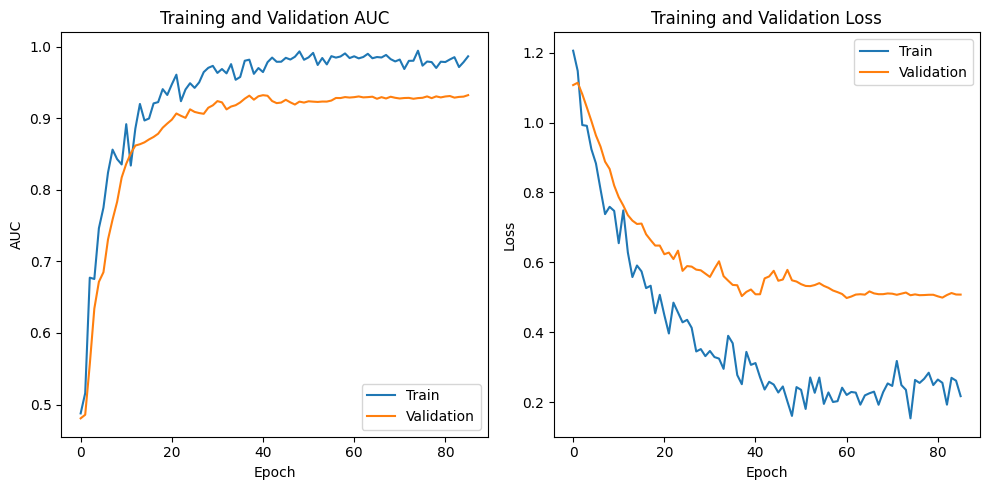

In [512]:
#Plot metrics
traintest.plot_metrics(history)

## Evaluate using test data

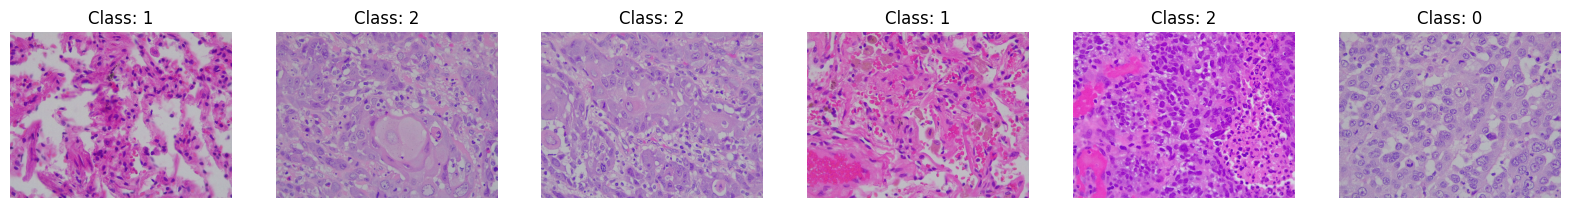

In [13]:
test_generator.show_generator()

2024-03-18 08:40:43.078899: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2024-03-18 08:40:44.492832: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Test AUC: 0.94
Test Accuracy: 0.82
Test Precision: 0.82
Test Recall: 0.84


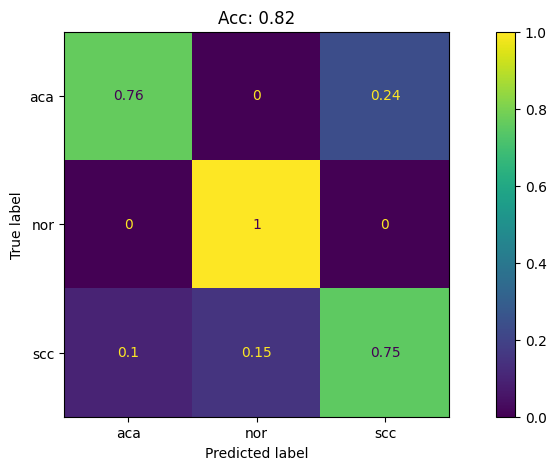

In [14]:
traintest.test_model(model, test_generator, class_names)

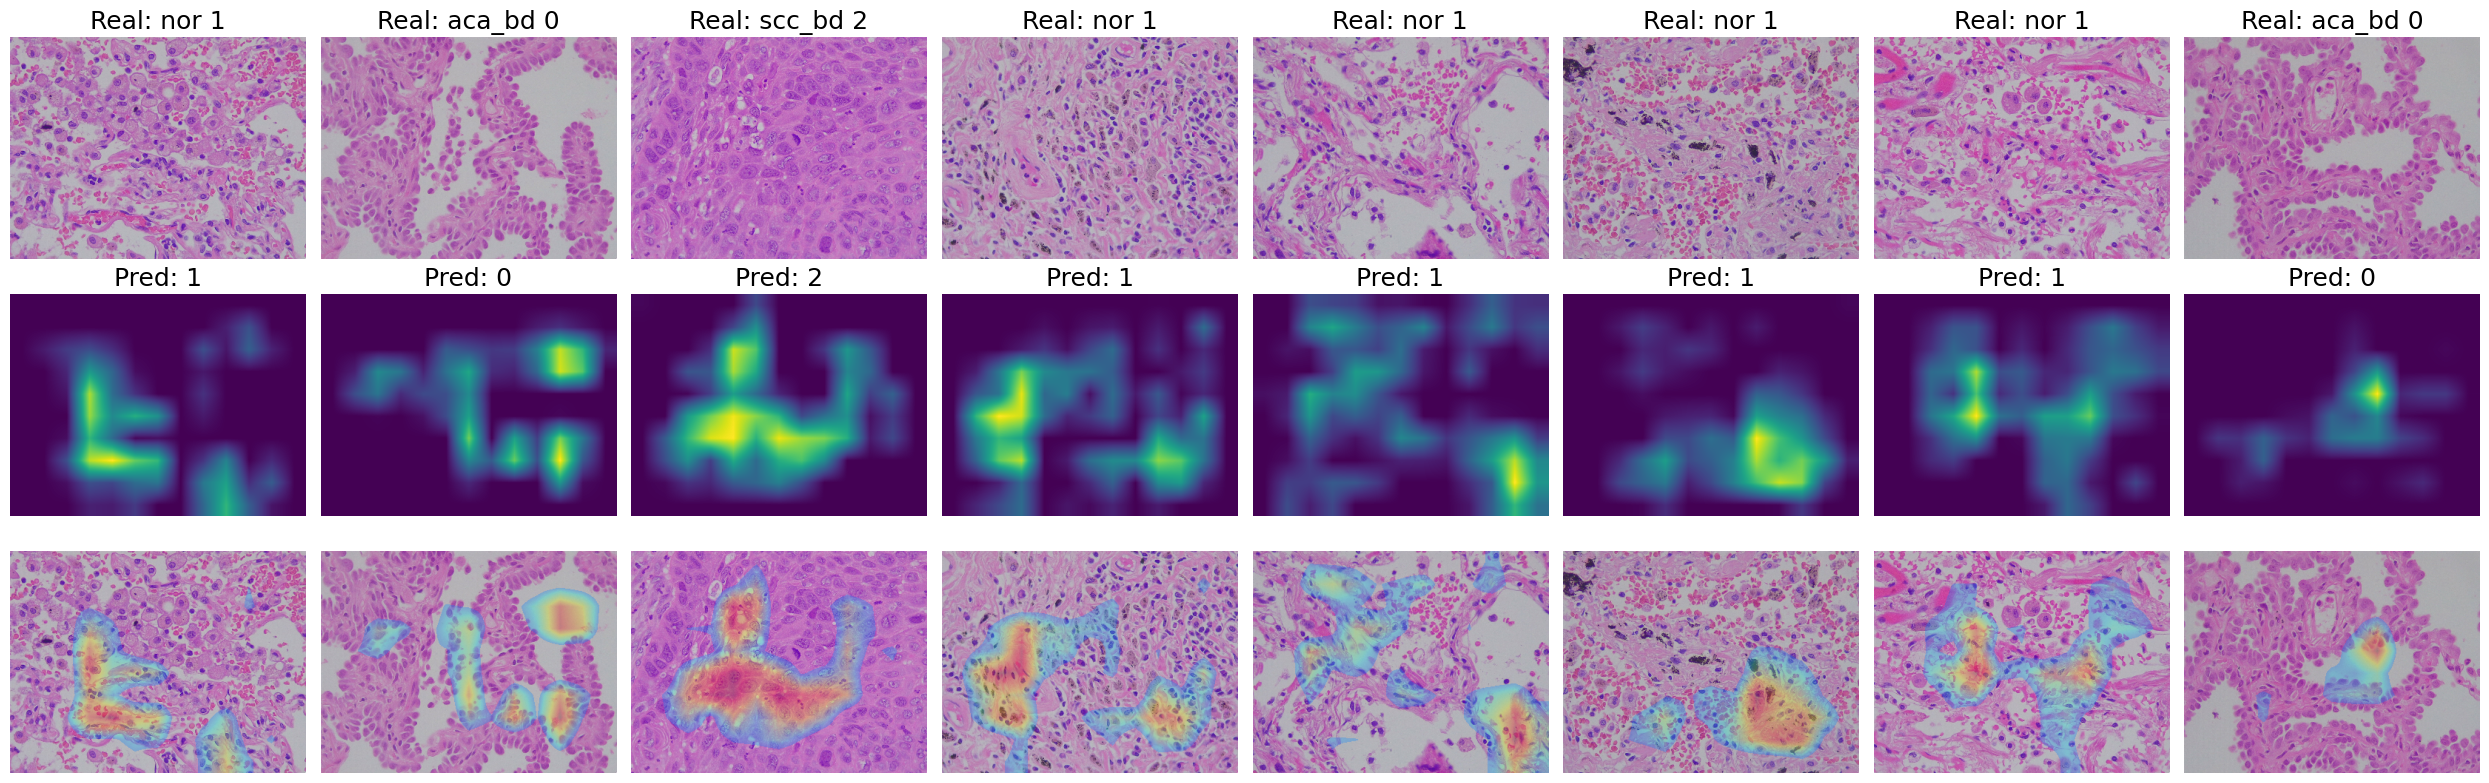

In [15]:
gradcam.generate_gradcam_samples(model, val_generator)

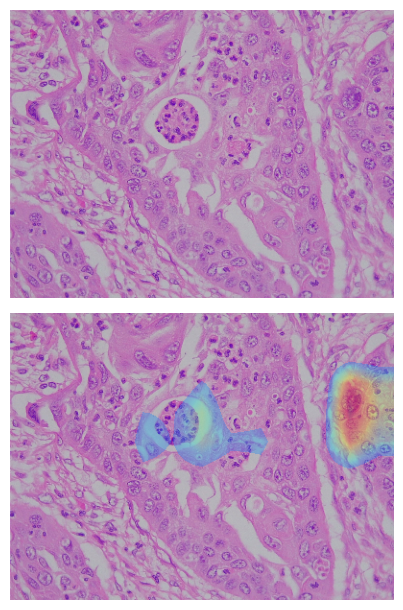

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
ims = [
    #'data/dataset_w_HC/aca_md/aca_md_40x_59.jpg',
    #'data/dataset_w_HC/nor/nor_40x_98.jpg',
    'data/dataset_w_HC/scc_bd/scc_bd_40x_45.jpg',
]
fig, axs = plt.subplots(2,1, figsize=(12,6.2))
for i in range(1):
    img = plt.imread(ims[i])
    img = np.expand_dims(cv2.resize(img, (400, 300))/255, 0)
    heat = gradcam.make_gradcam_heatmap(img, model, 'conv5_block3_3_conv')
    heat = cv2.resize(heat, dsize=(400, 300))
    axs[0].imshow(img[0])
    axs[1].imshow(gradcam.merge_image_mask(img[0], heat, mask_thresh=0.25))
    axs[0].axis('off')
    axs[1].axis('off')
plt.tight_layout()
plt.show()

In [123]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread('data/dataset_w_HC/scc_bd/scc_bd_40x_30.jpg')
img = np.expand_dims(cv2.resize(img, (400, 300))/255, 0)
heat = gradcam.make_gradcam_heatmap(img, model, 'conv5_block3_3_conv')
heat = cv2.resize(heat, dsize=(400, 300))

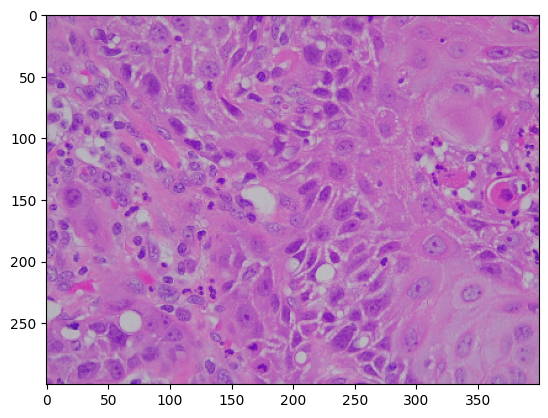

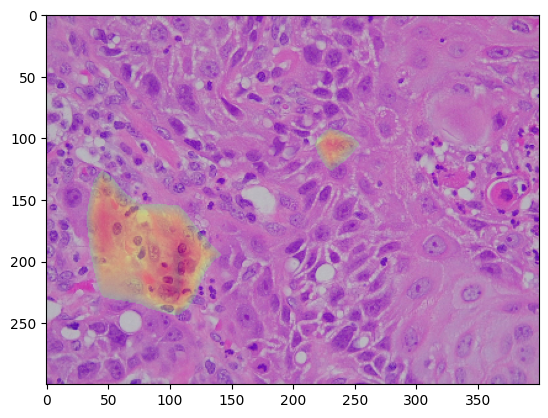

In [126]:
plt.imshow(img[0])
plt.show()
plt.imshow(gradcam.merge_image_mask(img[0], heat))

In [1]:
model.predict(img)

NameError: name 'model' is not defined